# **BERT**

---

**Table of contents:**
1. [Getting Started with Pretrained Models](https://colab.research.google.com/drive/1ZbO9BtH14pcxIyiZkMq4lWJToaTYSxOv#scrollTo=McJlxkDESTxd&line=1&uniqifier=1)
2. [Fine-tuning BERT for Text Classification](https://colab.research.google.com/drive/1ZbO9BtH14pcxIyiZkMq4lWJToaTYSxOv#scrollTo=grhPPLHBmjzT)
3. [Fine-tuning BERT for Entity-recognition](https://colab.research.google.com/drive/1ZbO9BtH14pcxIyiZkMq4lWJToaTYSxOv#scrollTo=FRq650Ox435j&line=1&uniqifier=1)
4. [Multilingual models](https://colab.research.google.com/drive/1ZbO9BtH14pcxIyiZkMq4lWJToaTYSxOv#scrollTo=agfZDQ3i0bu4&line=1&uniqifier=1)

**References:**
1. https://huggingface.co/docs/transformers/en/model_doc/distilbert
2. https://huggingface.co/docs/transformers/en/model_doc/bert
3. https://aclanthology.org/P19-1493.pdf

# Getting Started with Pretrained Model

In this section, we will look into using pretrained model like BERT or DistilledBERT for a text classification task particularly sentiment analysis.

First, we will start by installing Hugginface Transformer Library [https://huggingface.co/](https://huggingface.co/).

References: https://arxiv.org/abs/1810.04805

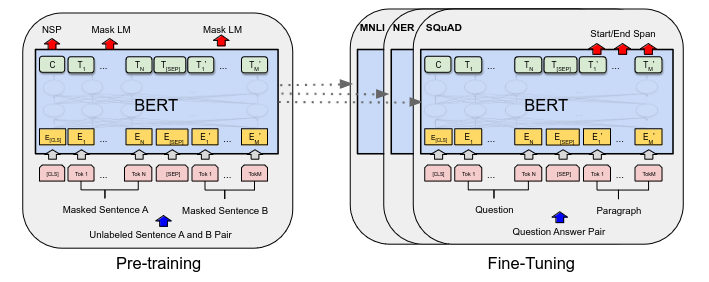

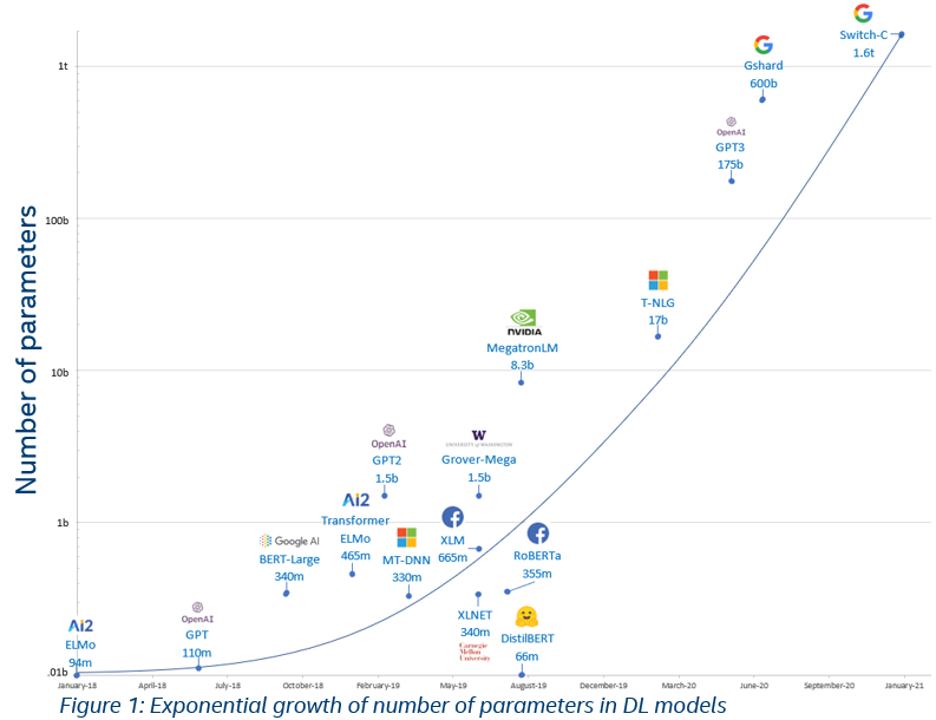

In [1]:
!pip install transformers

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import torch
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer, DistilBertModel, BertTokenizer, BertModel

### Importing the dataset of sentiment analysis

In [2]:
# Dataset source reference: https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv
# The dataset is in Tab Separated Values format. We will use pandas to read the data and load it as dataframe.

df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

""" Dataset format

sentence  label = 0,1 (Negative 0, Positive 1)

---Samples---

a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films 1
apparently reassembled from the cutting room floor of any given daytime soap  0
"""

df.head()

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [3]:
# Get only subset of the data for demonstration
batch = df[:3000]
batch

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1
...,...,...
2995,"but this new jangle of noise , mayhem and stup...",0
2996,darkly funny and frequently insightful,1
2997,"formuliac , but fun",1
2998,there 's some good material in their story abo...,0


In [4]:
batch[1].value_counts()

,count
1,
1,1565
0,1435


In [5]:
# https://huggingface.co/distilbert/distilbert-base-uncased
# https://arxiv.org/pdf/1910.01108


model_class, tokenizer_class, model_name = (DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased')


## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, model_name = (BertModel, BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(model_name)
model = model_class.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
model = model.to('cuda')

In [7]:
batch_list= batch[0].tolist()
print(len(batch_list))

print(batch_list[0])

print(tokenizer.tokenize(batch_list[0]))
print(tokenizer.encode(tokenizer.tokenize(batch_list[0])))                         #add_special_tokens=True
print(tokenizer.decode(tokenizer.encode(tokenizer.tokenize(batch_list[0]))))

#Special Tokens
print(tokenizer.decode([101]))
print(tokenizer.decode([102]))
print()

print("=== Tokenizer special tokens ===")
print(tokenizer.add_special_tokens)

3000
a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
['a', 'stirring', ',', 'funny', 'and', 'finally', 'transporting', 're', 'imagining', 'of', 'beauty', 'and', 'the', 'beast', 'and', '1930s', 'horror', 'films']
[101, 1037, 18385, 1010, 6057, 1998, 2633, 18276, 2128, 16603, 1997, 5053, 1998, 1996, 6841, 1998, 5687, 5469, 3152, 102]
[CLS] a stirring, funny and finally transporting re imagining of beauty and the beast and 1930s horror films [SEP]
[CLS]
[SEP]

=== Tokenizer special tokens ===
<bound method SpecialTokensMixin.add_special_tokens of DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstri

In [8]:
# Tokenization
# Our first step is to tokenize the sentences -- break them up into word and
# Subwords in the format BERT is comfortable with.

tokenized = batch[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized

,0
0,"[101, 1037, 18385, 1010, 6057, 1998, 2633, 182..."
1,"[101, 4593, 2128, 27241, 23931, 2013, 1996, 62..."
2,"[101, 2027, 3653, 23545, 2037, 4378, 24185, 10..."
3,"[101, 2023, 2003, 1037, 17453, 14726, 19379, 1..."
4,"[101, 5655, 6262, 1005, 1055, 12075, 2571, 376..."
...,...
2995,"[101, 2021, 2023, 2047, 23769, 2571, 1997, 500..."
2996,"[101, 27148, 6057, 1998, 4703, 12369, 3993, 102]"
2997,"[101, 2433, 20922, 2278, 1010, 2021, 4569, 102]"
2998,"[101, 2045, 1005, 1055, 2070, 2204, 3430, 1999..."


In [9]:
# Padding

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
print("Max Length: ", max_len)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(padded).shape

Max Length:  66


(3000, 66)

In [10]:
# Masking
# If we directly send `padded` to BERT, that would slightly confuse it.
# We need to create another variable to tell it to ignore (mask) the padding
# We've added when it's processing its input. That's what attention_mask is:

attention_mask = np.where(padded != 0, 1, 0) # If padded !=0, 1 else 0
print(attention_mask.shape)
print(attention_mask[:2, :])

(3000, 66)
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [11]:
# Getting vectors

input_ids = torch.tensor(padded).to('cuda')
attention_mask = torch.tensor(attention_mask).to('cuda')

In [12]:
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

last_hidden_states['last_hidden_state'].size()

torch.Size([3000, 66, 768])

a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films => contextual representation of a sentence dim 768

In [15]:
# Features
features = last_hidden_states[0][:,0,:].cpu().numpy() # vector representation of a sentence
labels = batch[1] # values
print(features.shape)
print(features)

(3000, 768)
[[-0.21593395 -0.14028892  0.00831091 ... -0.13694847  0.5867004
   0.20112719]
 [-0.17262752 -0.1447619   0.00223391 ... -0.17442574  0.2138649
   0.3719746 ]
 [-0.0506337   0.07203953 -0.02959705 ... -0.07148948  0.7185235
   0.26225436]
 ...
 [-0.23265567 -0.11099272  0.08604338 ...  0.00096529  0.32407793
   0.3780848 ]
 [ 0.0466651  -0.12419882 -0.06242234 ... -0.16781625  0.4982966
   0.21836   ]
 [-0.3572135  -0.11134697 -0.09630551 ... -0.04596794  0.3001686
   0.06558303]]


In [16]:
# Split - Train, Test
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [18]:
train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((2250, 768), (2250,), (750, 768), (750,))

In [19]:
lr_clf = LogisticRegression()

lr_clf.fit(train_features, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [20]:
# Evaluating model
lr_clf.score(test_features, test_labels)

0.8666666666666667

# Fine-tuning BERT for Text Classification

In [21]:
#check for GPU access
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [22]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=19572ca9b97fb134459664dcd0e9b49b2cfe96677ca5de54b9567fd9c08701b7
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [23]:
# Downloading dataset
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [24]:
# Unzip the dataset to the file system. You can browse the file system of
# The Colab instance in the sidebar on the left.

if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [25]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
3365,l-93,0,*,In the corner lay a dog.
4707,ks08,1,NaN,Frances has had her clean the drapes.
6226,c_13,0,*,I blew up it.
468,bc01,1,NaN,He fed the children.
6017,c_13,1,NaN,Sylvia will be slapping Jeff upside the head i...
3358,l-93,1,NaN,Sylvia squirmed.
377,bc01,1,NaN,How did you solve the problem?
5266,b_82,1,NaN,It is obvious that John is a fool.
8207,ad03,1,NaN,I like Anson
6595,g_81,1,NaN,A man just came in and a woman went out who ha...


In [26]:
# Sample five sentences which are labeled as not grammatically acceptable.
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
147,"It is important the more you to eat, the more ...",0
357,How do you wonder whether Mary solved the prob...,0
3648,The monkey eager to leave the meeting.,0
2585,Cora coiled at the rope around the post.,0
1648,I brought John a razor with which to shave mys...,0


In [27]:
# Get the lists of sentences and their labels

sentences = df.sentence.values
labels = df.label.values

### BERT Tokenizer

#### Transformers handles tokenization with:
1. tokenizer_config.json
1. vocab.txt
1. tokenizer.json
1. config.json

In [28]:
from transformers import BertTokenizer

# Load the BERT tokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# to see BERT tokenizer vocab file: https://huggingface.co/google-bert/bert-base-uncased/blob/main/vocab.txt

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [29]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


When we actually convert all of our sentences, we’ll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately.

#### Formatting

1. Add special tokens to the start and end of the sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".

In [30]:
# The transformers library provides a helpful `encode` function which will handle
# most of the parsing and data prep steps for us.

# Find max length
max_len = 0

# For every sentence
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Max sentence length:  47


Let take maximum length to 64

The `tokenizer.encode_plus` function combines multiple steps for us:
1. Split the sentence into tokens.
2. Add the special [CLS] and [SEP] tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.

The first four features are in `tokenizer.encode`, but we will use `tokenizer.encode_plus`
to get the fifth item (attention masks). Documentation is here: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('attention mask: ', attention_masks[0])
print('Label: ', labels[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
attention mask:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Label:  tensor(1)


In [ ]:
# Training & Validation Split
# Divide up our training set to use 90% for training and 10% for validation.

from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


In [ ]:
# We’ll also create an iterator for our dataset using the torch DataLoader class.
# This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory.

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

Here is the current list of classes provided for fine-tuning:
- BertModel
- BertForPreTraining
- BertForMaskedLM
- BertForNextSentencePrediction
- BertForSequenceClassification - The one we’ll use.
- BertForTokenClassification
- BertForQuestionAnswering
The documentation for these can be found under here: https://huggingface.co/transformers/v2.2.0/model_doc/bert.html

We’ll be using BertForSequenceClassification. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# We can get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Batch size: 32
# Learning rate (Adam): 2e-5
# Number of epochs: 4
# eps = 1e-8,  very small number to prevent any division by zero in the implementation

# Note: AdamW is a class from the huggingface library (as opposed to pytorch)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**Steps**

**Training:**
1. Unpack our data inputs and labels
2. Load data onto the GPU for acceleration
3. Clear out the gradients calculated in the previous pass.
4. In pytorch the gradients accumulate by default (useful for things like RNNs unless you explicitly clear them out.
5. Forward pass (feed input data through the network)
6. Backward pass (backpropagation)
7. Tell the network to update parameters with optimizer.step()
8. Track variables for monitoring progress

**Evalution:**
1. Unpack our data inputs and labels
2. Load data onto the GPU for acceleration
3. Forward pass (feed input data through the network)
4. Compute loss on our validation data and track variables for monitoring progress
Pytorch hides all of the detailed calculations from us, but we’ve commented the code to point out which of the above steps are happening on each line.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

epochs = 5

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

  # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        result = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
        # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here
            # https://huggingface.co/docs/transformers/v4.42.0/en/model_doc/bert#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

            loss, logits = outputs.loss, outputs.logits

            # print(loss)
            # Accumulate the validation loss.
            total_eval_loss += loss

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("Validation Loss: {0:.2f}".format(avg_val_loss))
    print("Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
         {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print()
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 5 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:15.
  Batch    80  of    241.    Elapsed: 0:00:27.
  Batch   120  of    241.    Elapsed: 0:00:39.
  Batch   160  of    241.    Elapsed: 0:00:52.
  Batch   200  of    241.    Elapsed: 0:01:05.
  Batch   240  of    241.    Elapsed: 0:01:18.

Average training loss: 0.51
Training epoch took: 0:01:18

Running Validation...
Accuracy: 0.83
Validation Loss: 0.38
Validation took: 0:00:03

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:14.
  Batch    80  of    241.    Elapsed: 0:00:27.
  Batch   120  of    241.    Elapsed: 0:00:41.
  Batch   160  of    241.    Elapsed: 0:00:54.
  Batch   200  of    241.    Elapsed: 0:01:07.
  Batch   240  of    241.    Elapsed: 0:01:20.

Average training loss: 0.32
Training epoch took: 0:01:21

Running Validation...
Accuracy: 0.84
Validation Loss: 0.38
Validation took: 0:00:03

======== Epoch 3 / 5 ========
Training...
  Batch    40  of    

In [ ]:
# Viewing the training statistics
for stats in training_stats:
  print(stats)

{'epoch': 1, 'Training Loss': 0.5054593213613597, 'Valid. Loss': tensor(0.3769, device='cuda:0'), 'Valid. Accur.': 0.8314043209876544, 'Training Time': '0:01:18', 'Validation Time': '0:00:03'}
{'epoch': 2, 'Training Loss': 0.31613149561946324, 'Valid. Loss': tensor(0.3756, device='cuda:0'), 'Valid. Accur.': 0.8406635802469137, 'Training Time': '0:01:21', 'Validation Time': '0:00:03'}
{'epoch': 3, 'Training Loss': 0.2019101475129731, 'Valid. Loss': tensor(0.4530, device='cuda:0'), 'Valid. Accur.': 0.8483796296296297, 'Training Time': '0:01:21', 'Validation Time': '0:00:03'}
{'epoch': 4, 'Training Loss': 0.13459859471149835, 'Valid. Loss': tensor(0.4938, device='cuda:0'), 'Valid. Accur.': 0.845679012345679, 'Training Time': '0:01:20', 'Validation Time': '0:00:03'}
{'epoch': 5, 'Training Loss': 0.11575311869460146, 'Valid. Loss': tensor(0.4938, device='cuda:0'), 'Valid. Accur.': 0.845679012345679, 'Training Time': '0:01:20', 'Validation Time': '0:00:03'}


# Fine-tuning BERT for Entity-recognition

In [ ]:
!wget https://raw.githubusercontent.com/yrnigam/Named-Entity-Recognition-NER-using-LSTMs/master/ner_dataset.csv

--2024-09-03 07:08:26--  https://raw.githubusercontent.com/yrnigam/Named-Entity-Recognition-NER-using-LSTMs/master/ner_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15208151 (15M) [application/octet-stream]
Saving to: ‘ner_dataset.csv’

ner_dataset.csv     100%[===================>]  14.50M  40.1MB/s    in 0.4s    

2024-09-03 07:08:28 (40.1 MB/s) - ‘ner_dataset.csv’ saved [15208151/15208151]



In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForTokenClassification

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)


cuda


In [ ]:
data = pd.read_csv("/content/ner_dataset.csv", encoding='unicode_escape')
data.head()


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
data.count()

,0
Sentence #,47959
Word,1048565
POS,1048575
Tag,1048575


In [ ]:
print("Number of tags: {}".format(len(data.Tag.unique())))
frequencies = data.Tag.value_counts()
frequencies

Number of tags: 17


,count
Tag,
O,887908
B-geo,37644
B-tim,20333
B-org,20143
I-per,17251
B-per,16990
I-org,16784
B-gpe,15870
I-geo,7414


In [ ]:
tags = {}
for tag, count in zip(frequencies.index, frequencies):
    if tag != "O":
        if tag[2:5] not in tags.keys():
            tags[tag[2:5]] = count
        else:
            tags[tag[2:5]] += count
    continue

print(sorted(tags.items(), key=lambda x: x[1], reverse=True))

[('geo', 45058), ('org', 36927), ('per', 34241), ('tim', 26861), ('gpe', 16068), ('art', 699), ('eve', 561), ('nat', 252)]


In [ ]:
# pandas has a very handy "forward fill" function to fill missing values based on the last upper non-nan value
data = data.fillna(method='ffill')
data.head()

<ipython-input-47-22549ca49efa>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
# let's create a new column called "sentence" which groups the words by sentence
data['sentence'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Word'].transform(lambda x: ' '.join(x))
# let's also create a new column called "word_labels" which groups the tags by sentence
data['word_labels'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))
data.head()

,Sentence #,Word,POS,Tag,sentence,word_labels
0,Sentence: 1,Thousands,NNS,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
1,Sentence: 1,of,IN,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
2,Sentence: 1,demonstrators,NNS,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
3,Sentence: 1,have,VBP,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
4,Sentence: 1,marched,VBN,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."


In [ ]:
label2id = {k: v for v, k in enumerate(data.Tag.unique())}
id2label = {v: k for v, k in enumerate(data.Tag.unique())}
label2id

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16}

In [ ]:
data = data[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
data.head()

,sentence,word_labels
0,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
1,Families of soldiers killed in the conflict jo...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-per,O,O,..."
2,They marched from the Houses of Parliament to ...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,I-geo,O"
3,"Police put the number of marchers at 10,000 wh...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,The protest comes on the eve of the annual con...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,O,O,B-org,I-org,O,..."


In [ ]:
len(data)

47610

In [ ]:
print(data.iloc[41].sentence)
print(data.iloc[41].word_labels)

Bedfordshire police said Tuesday that Omar Khayam was arrested in Bedford for breaching the conditions of his parole .
B-gpe,O,O,B-tim,O,B-per,I-per,O,O,O,B-geo,O,O,O,O,O,O,O,O


### Preparing the dataset and dataloader

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 2
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

We further need to pre-process the data according to the tokenization. Since BERT uses Word Piece tokenizer. The output labels should also be matched with the tokens.

For example, if you have word like "Washington" which is labeled as "b-gpe", but it gets tokenized to "Wash", "##ing", "##ton", then we will have to propagate the word's original label to all of its wordpieces: "b-gpe", "b-gpe", "b-gpe". The model should be able to produce the correct labels for each individual wordpiece.

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    """
    Word piece tokenization makes it difficult to match word labels
    back up with individual word pieces. This function tokenizes each
    word one at a time so that it is easier to preserve the correct
    label for each subword.
    """

    tokenized_sentence = []
    labels = []

    sentence = sentence.strip()

    for word, label in zip(sentence.split(), text_labels.split(",")):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # step 1: tokenize (and adapt corresponding labels)
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index]
        tokenized_sentence, labels = tokenize_and_preserve_labels(sentence, word_labels, self.tokenizer)

        # step 2: add special tokens (and corresponding labels)
        tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"] # add special tokens
        labels.insert(0, "O") # add outside label for [CLS] token
        labels.insert(-1, "O") # add outside label for [SEP] token

        # step 3: truncating/padding
        maxlen = self.max_len

        if (len(tokenized_sentence) > maxlen):
          # truncate
          tokenized_sentence = tokenized_sentence[:maxlen]
          labels = labels[:maxlen]
        else:
          # pad
          tokenized_sentence = tokenized_sentence + ['[PAD]'for _ in range(maxlen - len(tokenized_sentence))]
          labels = labels + ["O" for _ in range(maxlen - len(labels))]

        # step 4: obtain the attention mask
        attn_mask = [1 if tok != '[PAD]' else 0 for tok in tokenized_sentence]

        # step 5: convert tokens to input ids
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]
        # the following line is deprecated
        #label_ids = [label if label != 0 else -100 for label in label_ids]

        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(attn_mask, dtype=torch.long),
              #'token_type_ids': torch.tensor(token_ids, dtype=torch.long),
              'targets': torch.tensor(label_ids, dtype=torch.long)
        }

    def __len__(self):
        return self.len

We divide the train/test split. Let's us split it in 80:20 ratio.

In [ ]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("Dataset: {}".format(data.shape))
print("Training set: {}".format(train_dataset.shape))
print("Test set: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)


Dataset: (47610, 2)
Training set: (38088, 2)
Test set: (9522, 2)


In [ ]:
# Sample training tensor
training_set[0]

{'ids': tensor([  101,  1996,  4311,  2360,  9587,  7898,  2368, 11937, 12002,  5833,
          2072,  1011,  1037,  4738,  4944,  1011,  3478,  9317,  2000,  2663,
          1037,  3789,  1997,  7023,  1010,  2044,  2375, 12088,  5275,  2002,
          2001,  2025,  4591,  2000,  2448,  1996,  2035,  1011,  2590,  3757,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,  

In [ ]:
training_set[0]["ids"]

tensor([  101,  1996,  4311,  2360,  9587,  7898,  2368, 11937, 12002,  5833,
         2072,  1011,  1037,  4738,  4944,  1011,  3478,  9317,  2000,  2663,
         1037,  3789,  1997,  7023,  1010,  2044,  2375, 12088,  5275,  2002,
         2001,  2025,  4591,  2000,  2448,  1996,  2035,  1011,  2590,  3757,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
# print the first 30 tokens and corresponding labels
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["ids"][:30]), training_set[0]["targets"][:30]):
  print('{0:10}  {1}'.format(token, id2label[label.item()]))

[CLS]       O
the         O
reports     O
say         O
mo          B-geo
##hs        B-geo
##en        B-geo
ta          I-geo
##sal       I-geo
##out       I-geo
##i         I-geo
-           O
a           O
trained     O
architect   O
-           O
failed      O
wednesday   B-tim
to          O
win         O
a           O
vote        O
of          O
confidence  O
,           O
after       O
law         O
##makers    O
argued      O
he          O


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)


In [ ]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased',
                                                   num_labels=len(id2label),
                                                   id2label=id2label,
                                                   label2id=label2id)
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
ids = training_set[0]["ids"].unsqueeze(0)
mask = training_set[0]["mask"].unsqueeze(0)
targets = training_set[0]["targets"].unsqueeze(0)

ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)

outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
initial_loss = outputs[0]
initial_loss

tensor(3.1837, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 17])

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader):

        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss, tr_logits = outputs.loss, outputs.logits
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
        active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
        targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_preds.extend(predictions)
        tr_labels.extend(targets)

        tmp_tr_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)


Training epoch: 1
Training loss per 100 training steps: 3.1116316318511963
Training loss per 100 training steps: 0.6180755512991755
Training loss per 100 training steps: 0.39348074621451434
Training loss per 100 training steps: 0.30111586959704606
Training loss per 100 training steps: 0.2490177546346797
Training loss per 100 training steps: 0.2161014138938424
Training loss per 100 training steps: 0.19214582169884056
Training loss per 100 training steps: 0.17370516244792372
Training loss per 100 training steps: 0.1590852924313317
Training loss per 100 training steps: 0.14841373070307515
Training loss per 100 training steps: 0.13875256921141432
Training loss per 100 training steps: 0.13073556807668682
Training loss per 100 training steps: 0.12380978828769093
Training loss per 100 training steps: 0.11782635079602283
Training loss per 100 training steps: 0.11287565567802577
Training loss per 100 training steps: 0.10827505120791639
Training loss per 100 training steps: 0.10397476377271041
T

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)

            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(targets)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    #print(eval_labels)
    #print(eval_preds)

    labels = [id2label[id.item()] for id in eval_labels]
    predictions = [id2label[id.item()] for id in eval_preds]

    #print(labels)
    #print(predictions)

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [ ]:
labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.0018971192184835672
Validation loss per 100 evaluation steps: 0.033751963474960664
Validation loss per 100 evaluation steps: 0.027714759582767017
Validation loss per 100 evaluation steps: 0.026736799135134208
Validation loss per 100 evaluation steps: 0.02564326958621623
Validation loss per 100 evaluation steps: 0.02663720307277627
Validation loss per 100 evaluation steps: 0.02631594165103829
Validation loss per 100 evaluation steps: 0.026495101542266083
Validation loss per 100 evaluation steps: 0.026448850092658426
Validation loss per 100 evaluation steps: 0.02660443859080357
Validation loss per 100 evaluation steps: 0.0261843684926992
Validation loss per 100 evaluation steps: 0.0261975339554613
Validation loss per 100 evaluation steps: 0.025671298620594633
Validation loss per 100 evaluation steps: 0.026062168426181736
Validation loss per 100 evaluation steps: 0.025974851168994024
Validation loss per 100 evaluation steps: 0.025975921841582615

In [ ]:
!pip install seqeval

In [ ]:
from seqeval.metrics import classification_report

print(classification_report([labels], [predictions]))

In [ ]:
sentence = "India has a capital called Mumbai. On wednesday, the president will give a presentation"

inputs = tokenizer(sentence, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)
# forward pass
outputs = model(ids, mask)
logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [id2label[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

word_level_predictions = []
for pair in wp_preds:
  if (pair[0].startswith(" ##")) or (pair[0] in ['[CLS]', '[SEP]', '[PAD]']):
    # skip prediction
    continue
  else:
    word_level_predictions.append(pair[1])

# we join tokens, if they are not special ones
str_rep = " ".join([t[0] for t in wp_preds if t[0] not in ['[CLS]', '[SEP]', '[PAD]']]).replace(" ##", "")
print(str_rep)
print(word_level_predictions)


india has a capital called mumbai . on wednesday , the president will give a presentation
['B-geo', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
from transformers import pipeline

pipe = pipeline(task="token-classification", model=model.to("cpu"), tokenizer=tokenizer, aggregation_strategy="simple")
pipe("My name is Niels and New York is a city")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'entity_group': 'per',
  'score': 0.8097761,
  'word': 'ni',
  'start': None,
  'end': None},
 {'entity_group': 'per',
  'score': 0.89605117,
  'word': '##els',
  'start': None,
  'end': None},
 {'entity_group': 'geo',
  'score': 0.90522546,
  'word': 'new york',
  'start': None,
  'end': None}]

**Saving the Model**

We need save our model and tokenier using `model.save_pretrained()` and `tokenizer.save_pretrained()`.

In [ ]:
model.save_pretrained('/content/bert-ft-ner/')

tokenizer.save_pretrained('/content/bert-ft-ner/')

('/content/bert-ft-ner/tokenizer_config.json',
 '/content/bert-ft-ner/special_tokens_map.json',
 '/content/bert-ft-ner/vocab.txt',
 '/content/bert-ft-ner/added_tokens.json')

# Multilingual models

Huggingface also supports multiple multilingual model. Such as multilingual variants of BERT architecture such as `bert-base-multilingual-uncased` and `bert-base-multilingual-cased` pretrained on monolingual data of 102 and 104 languages respectively.

In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
model_class, tokenizer_class, model_name = (BertModel, BertTokenizer, 'bert-base-multilingual-uncased')

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
# model = BertModel.from_pretrained('bert-base-multilingual-uncased')
# model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
sent = "El trato muy bueno, muy amables, el arroz exquisito y a mitad de precio, lo recomiendo." # <-- SPANISH

print(f"Original sentence: {sent}")

inp_tok = tokenizer.tokenize(sent)
inp_ids = tokenizer.convert_tokens_to_ids(inp_tok)

print(f"Input tokens: {inp_tok}")
print(f"Token ids: {inp_ids}")

In [ ]:
print(tokenizer.convert_ids_to_tokens(inp_ids))

['el', 'trato', 'muy', 'bueno', ',', 'muy', 'ama', '##bles', ',', 'el', 'arroz', 'ex', '##quis', '##ito', 'y', 'a', 'mitad', 'de', 'precio', ',', 'lo', 'rec', '##omi', '##endo', '.']


In [ ]:
tokenizer.decode(inp_ids)

'el trato muy bueno, muy amables, el arroz exquisito y a mitad de precio, lo recomiendo.'

In [ ]:
sent = "हेलो इंडिया" # <-- Hindi
print(tokenizer.tokenize(sent))

['ह', '##लो', 'इडिया']


In [ ]:
# https://github.com/google-research/bert/blob/master/multilingual.md
# model_class, tokenizer_class, model_name = (BertModel, BertTokenizer, 'bert-base-multilingual-cased')

tokenizer_multi = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
sent = "हेलो इंडिया" # <-- Hindi
print(tokenizer_multi.tokenize(sent))

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

['हे', '##ल', '##ो', 'इंडिया']


In [ ]:
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer

en_text = "Do not meddle in the affairs of wizards, for they are subtle and quick to anger."
chinese_text = "不要插手巫師的事務, 因為他們是微妙的, 很快就會發怒."

tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M", src_lang="zh")
model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M") # <-- Model size 1.94 G

In [ ]:
encoded_zh = tokenizer(chinese_text, return_tensors="pt")

In [ ]:
generated_tokens = model.generate(**encoded_zh, forced_bos_token_id=tokenizer.get_lang_id("en"))
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

['Do not interfere with the matters of the witches, because they are delicate and will soon be angry.']

In [ ]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

en_text = ["Do not meddle in the affairs of wizards, for they are subtle and quick to anger."]
fi_text = ["Älä sekaannu velhojen asioihin, sillä ne ovat hienovaraisia ja nopeasti vihaisia."]

tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

In [ ]:
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt") # <-- Model size 2.44 GB

In [ ]:
print(model)

In [ ]:
print(type(tokenizer))

In [ ]:
tokenizer

In [ ]:
encoded_en = tokenizer(en_text, return_tensors="pt")
print(encoded_en)

In [ ]:
generated_tokens = model.generate(**encoded_en, forced_bos_token_id=250003)

In [ ]:
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

**External References:**

1. https://huggingface.co/docs/transformers/en/model_doc/m2m_100
2. https://huggingface.co/docs/transformers/en/model_doc/mbart